In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '16/05/2020'
id_noticia = '236172'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'

In [3]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [4]:
# Prepare
dfL.set_index(['Provincia'], inplace=True)
del dfL['Positivo PCR']
del dfL['UCI']
#dfL.rename(columns={'Hospitalización': 'Ingresados', 'Curados': 'Altas', 'Fallecimientos': 'Bajas'}, inplace=True)
dfL['Fecha'] = fecha

# A partir del 14/05/2020 se cambia el formato del dato añadiendo en la misma columna el número de nuevos casos
dfL['Hospitalización'] = dfL['Hospitalización'].str.split(' ').str[0]
dfL['Curados'] = dfL['Curados'].str.split(' ').str[0]
dfL['Fallecimientos'] = dfL['Fallecimientos'].str.split(' ').str[0]

dfL

,Hospitalización,Fallecimientos,Curados,Fecha
Provincia,,,,
Almería,224,51,474,16/05/2020
Cádiz,568,145,530,16/05/2020
Córdoba,552,105,1.335,16/05/2020
Granada,1.183,279,2.499,16/05/2020
Huelva,219,48,351,16/05/2020
Jaén,753,174,1.129,16/05/2020
Málaga,1.466,278,2.214,16/05/2020
Sevilla,1.196,275,1.787,16/05/2020
Total,6.161,1.355,10.319,16/05/2020


In [5]:
# Save to csv
campos_ordenados = ['Hospitalización','Curados','Fallecimientos','Fecha']
dfL[campos_ordenados].to_csv(filename, encoding='utf-8', header=False, mode='+a', index_label='Provincia')

In [6]:
# Load full csv
df = pd.read_csv(filename, thousands='.')

In [7]:
# Prepare
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
last_fecha = df['Fecha'].max()
df.set_index(['Provincia', 'Fecha'], inplace=True)
df.sort_index(inplace=True)

In [8]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').pct_change() * 100
dfV.tail()

Hospitalización   Curados  Fallecimientos
Provincia Fecha                                                
Total     2020-05-12         0.147735  0.999457        0.302572
          2020-05-13         0.213080  1.979133        0.452489
          2020-05-14         0.228983  4.609218        0.300300
          2020-05-15         0.293734  2.319016        0.598802
          2020-05-16         0.244061  1.685061        0.818452

In [9]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]

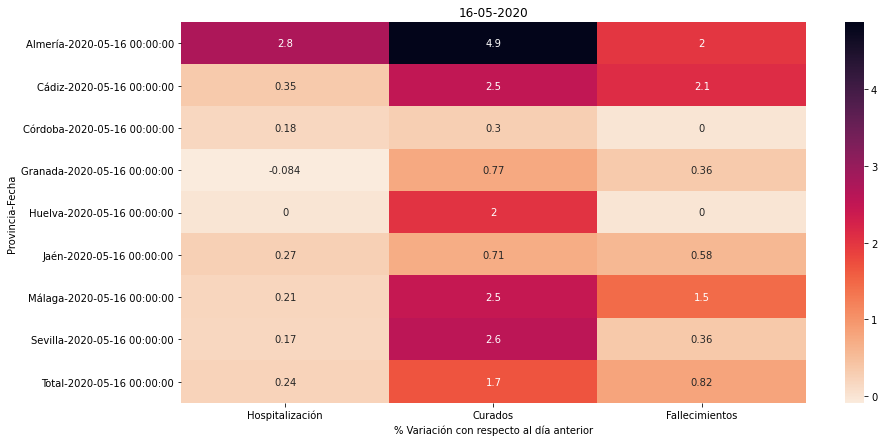

In [10]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG, annot=True, cmap=cmap)

# Add label for horizontal axis
plt.xlabel('% Variación con respecto al día anterior')
plt.show()

In [11]:
provincia = 'Huelva'
dias = 15
data = df.loc[provincia][['Hospitalización', 'Curados', 'Fallecimientos']].diff().tail(dias).copy()
titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia
# Correcciones
# El día 25/04/2020 el número de personas ingresadas calculado es negativo.
# Al ser datos acumulados lo que indica es una corrección en el número de ingresados acumulados a ese día
#data.loc['2020-04-25']['Hospitalizadas'] = 0

# El día 30/04/2020 aparecen 7 ingresos y los días anteriores y posteriores son 0 y -1
# Tiene pinta de ser un ajuste del cambio del día 25/04/2020
# data.loc['2020-04-30']['Hospitalización'] = 0

# El día 01/05/2020 el número de personas ingresadas calculado es negativo.
# Al ser datos acumulados lo que indica es una corrección en el número de ingresados acumulados a ese día
# data.loc['2020-05-01']['Hospitalización'] = 0

# El día 08/05/2020 el número de personas ingresadas calculado es negativo.
# Al ser datos acumulados lo que indica es una corrección en el número de ingresados acumulados a ese día
data.loc['2020-05-08']['Hospitalizadas'] = 0

In [12]:
print(titulo)
print(data)

Nuevos casos en los últimos 15 días en Huelva
            Hospitalización  Curados  Fallecimientos
Fecha                                               
2020-05-02              0.0     14.0             0.0
2020-05-03              0.0      2.0             0.0
2020-05-04              0.0      7.0             0.0
2020-05-05              0.0      0.0             0.0
2020-05-06              0.0      7.0             1.0
2020-05-07              0.0     10.0             0.0
2020-05-08             -1.0     39.0             1.0
2020-05-09              0.0     21.0             1.0
2020-05-10              0.0      7.0             1.0
2020-05-11              0.0      0.0             0.0
2020-05-12              0.0      6.0             0.0
2020-05-13              0.0     11.0             1.0
2020-05-14              0.0      8.0             0.0
2020-05-15              0.0     16.0             0.0
2020-05-16              0.0      7.0             0.0


Nuevos casos en los últimos 15 días en Huelva. (Nuevos ingresos hospitalarios)


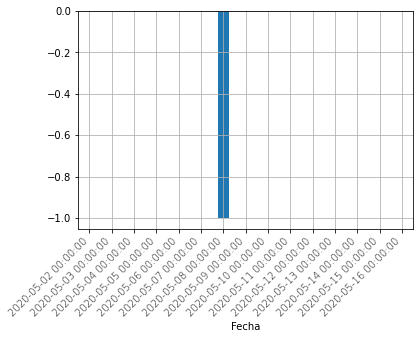

In [13]:
print(titulo + '. (Nuevos ingresos hospitalarios)')
data['Hospitalización'].plot(kind='bar', grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()